# Model 1: Credits Where Difficulties Ocurred

## Setup

**Imports:**

In [2]:
%reload_ext autoreload
%autoreload 1
import os
import warnings
import mlflow
from pprint import pprint
import random
import polars as pl
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from rgf.sklearn import RGFClassifier
import auxiliary.transformers as tr
from auxiliary.transformers import PolarsColumnTransformer as PCT
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import copy
import auxiliary.tuning as tunes
import auxiliary.eda_functions as eda
from ray import tune
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from BorutaShap import BorutaShap
import statistics
from sklearn.utils.validation import check_random_state
%aimport auxiliary.transformers
%aimport auxiliary.tuning
%aimport auxiliary.eda_functions

/home/gediminas/anaconda3/lib/python3.9/site-packages/pydantic/_internal/_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/home/gediminas/anaconda3/lib/python3.9/site-packages/pydantic/_internal/_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


**Settings:**

In [3]:
random.seed(1)
warnings.filterwarnings(
    "ignore", category=UserWarning, message="Cannot find FastRGF executable files.*"
)

**Loading the data:**

In [4]:
train_data=pl.read_parquet('temp/application_train_filtered.parquet')
id_and_target=['SK_ID_CURR','TARGET']
X_train=train_data.drop(columns=id_and_target)
y_train=train_data['TARGET']

**Specifying categoric numeric and boolean features:**

In [4]:
bool_features = []
for feature in X_train.select(pl.col(pl.Utf8)).columns:
    if X_train[feature].n_unique() == 2:
        bool_features.append(feature)

cat_features = [
    feature
    for feature in X_train.select(pl.col(pl.Utf8)).columns
    if feature not in bool_features
]

numeric_features_with_nulls = (
    pl.Series(
        X_train.select(pl.col(pl.FLOAT_DTYPES), pl.col(pl.INTEGER_DTYPES)).columns
    )
    .filter(
        X_train.select(pl.col(pl.FLOAT_DTYPES), pl.col(pl.INTEGER_DTYPES))
        .select(pl.all().is_null().any())
        .transpose()
        .to_series()
    )
    .to_list()
)

## Pipelines

### Preprocessing pipeline

In [5]:
preprocessing = Pipeline([])

num_imputer = tr.PolarsColumnTransformer([])
for feature in numeric_features_with_nulls:
    num_imputer.steps[feature] = PCT.Step(
        feature, tr.NumDiffFromRestImputer(), feature
    )
preprocessing.steps.insert(0,('num_imputer', num_imputer))

cat_imputers = tr.PolarsColumnTransformer([])
for feature in cat_features:
    cat_imputers.steps[feature] = PCT.Step(
        feature, tr.NotInImputerPolars(min_values=100, fill_value="other"), feature
    )
preprocessing.steps.append(("cat_imputers", cat_imputers))

encoders = tr.PolarsColumnTransformer([])
for feature in bool_features:
    encoders.steps[feature] = PCT.Step(
        feature, tr.PolarsOneHotEncoder(drop=True), feature
    )
for feature in cat_features:
    encoders.steps[feature] = PCT.Step(
        feature, tr.TargetMeanOrderedLabeler(how="label"), feature
    )
preprocessing.steps.append(("encoders", encoders))
preprocessing.steps.append(("emergency_null_imputer", tr.PolarsNullImputer(-9999)))
feature_remover = tr.FeatureRemover([])
preprocessing.steps.append(("feature_removal", feature_remover))

### Models and Sampling:

In [6]:
model_lgb=LGBMClassifier(n_jobs=1,verbosity=-1,force_col_wise=True)
sampler_model=tr.SamplingModelWrapper(model_lgb)
full_pipeline=Pipeline([('preprocess', preprocessing),('model',sampler_model)])

In [7]:
preprocessing_etrees=copy.deepcopy(preprocessing)
model_extra_trees = ExtraTreesClassifier(random_state=1,n_jobs=1)
sampler_model_etrees=tr.SamplingModelWrapper(model_extra_trees)
full_pipeline_etrees=Pipeline([('preprocess',preprocessing_etrees),('model',sampler_model_etrees)])


In [8]:
preprocessing_rgf = copy.deepcopy(preprocessing)
model_rgf = RGFClassifier()
sampler_model_rgf=tr.SamplingModelWrapper(model_rgf)
full_pipeline_rgf = Pipeline([("preprocess", preprocessing_rgf), ("model", sampler_model_rgf)])

## Feature Selection:

**Fitting Boruta Shap algorithm on LGBM models with different alpha regularization values**

**Creating lists of bad and tentative feature lists for each selection experiment:**

In [9]:
selector_with_alpha=joblib.load('temp/model_1_selector_alpha1.joblib')
selector_high_alpha=joblib.load('temp/model_1_selector_alpha10.joblib')
selector_no_alpha=joblib.load('temp/model_1_selector_alpha0.joblib')
bad_features_with_alpha=selector_with_alpha.features_to_remove.tolist()
bad_and_tentative_features_alpha=bad_features_with_alpha.copy()
bad_and_tentative_features_alpha.extend(selector_with_alpha.tentative.copy())


bad_features_high_alpha=selector_high_alpha.features_to_remove.tolist()
bad_and_tentative_features_high_alpha=bad_features_high_alpha.copy()
bad_and_tentative_features_high_alpha.extend(selector_high_alpha.tentative.copy())


bad_feature_no_alpha=selector_no_alpha.features_to_remove.tolist()
bad_and_tentative_features_no_alpha=bad_feature_no_alpha.copy()
bad_and_tentative_features_no_alpha.extend(selector_no_alpha.tentative.copy())


**Putting the feature quality data into a single data frame:**

In [10]:
feature_quality = {"feature": preprocessing.fit_transform(X_train, y_train).columns}
feature_quality["high_alpha"] = []
feature_quality["alpha"] = []
feature_quality["no_alpha"] = []

for feature in feature_quality["feature"]:
    if feature in bad_features_high_alpha:
        feature_quality["high_alpha"].append("bad")
    elif feature in selector_high_alpha.tentative:
        feature_quality["high_alpha"].append("tentative")
    else:
        feature_quality["high_alpha"].append("good")

for feature in feature_quality["feature"]:
    if feature in bad_features_with_alpha:
        feature_quality["alpha"].append("bad")
    elif feature in selector_with_alpha.tentative:
        feature_quality["alpha"].append("tentative")
    else:
        feature_quality["alpha"].append("good")

for feature in feature_quality["feature"]:
    if feature in bad_features_high_alpha:
        feature_quality["no_alpha"].append("bad")
    elif feature in selector_no_alpha.tentative:
        feature_quality["no_alpha"].append("tentative")
    else:
        feature_quality["no_alpha"].append("good")

feature_quality=pl.DataFrame(feature_quality)


**Features with no consensus:**

In [11]:
eda.table_display(feature_quality.filter(
    (pl.col("high_alpha") != pl.col("alpha"))
    | (pl.col("high_alpha") != pl.col("no_alpha"))
    | (pl.col("alpha") != pl.col("no_alpha"))
))


| feature                                   | high_alpha   | alpha     | no_alpha   |
|:------------------------------------------|:-------------|:----------|:-----------|
| AMT_INCOME_TOTAL                          | good         | good      | tentative  |
| DAYS_REGISTRATION                         | tentative    | good      | good       |
| FLAG_WORK_PHONE                           | tentative    | good      | good       |
| LIVINGAREA_MEDI                           | bad          | tentative | bad        |
| DEF_60_CNT_SOCIAL_CIRCLE                  | bad          | tentative | bad        |
| bureau_DAYS_CREDIT_ENDDATE_max            | tentative    | tentative | good       |
| bureau_AMT_CREDIT_MAX_OVERDUE_max         | tentative    | tentative | good       |
| bureau_AMT_CREDIT_SUM_mean                | tentative    | good      | good       |
| bureau_AMT_CREDIT_SUM_max                 | tentative    | tentative | good       |
| bureau_AMT_CREDIT_SUM_LIMIT_mean          | bad          | tentative | bad        |
| bureau_DAYS_CREDIT_mean                   | tentative    | good      | good       |
| bureau_DAYS_CREDIT_sum                    | bad          | tentative | bad        |
| bureau_DAYS_CREDIT_UPDATE_std             | bad          | tentative | bad        |
| bureau_DAYS_CREDIT_ENDDATE_mean_Active    | tentative    | good      | good       |
| bureau_DAYS_CREDIT_ENDDATE_mode_Active    | bad          | tentative | bad        |
| bureau_AMT_CREDIT_MAX_OVERDUE_mean_Active | bad          | tentative | bad        |
| bureau_AMT_CREDIT_SUM_mean_Active         | bad          | tentative | bad        |
| bureau_AMT_CREDIT_SUM_DEBT_sum_Active     | bad          | tentative | bad        |
| bureau_DAYS_CREDIT_mean_Active            | bad          | tentative | bad        |
| prev_AMT_CREDIT_mean_Approved             | bad          | tentative | bad        |
| prev_AMT_CREDIT_sum_Revolving_loans       | tentative    | tentative | good       |
| NAME_INCOME_TYPE                          | tentative    | good      | good       |
| NAME_HOUSING_TYPE                         | bad          | tentative | bad        |
| WALLSMATERIAL_MODE                        | bad          | tentative | bad        |
| NAME_CONTRACT_TYPE_Cash loans             | tentative    | good      | good       |

**Creating lists of bad and tentative features from consensus:**

In [12]:
feature_quality = feature_quality.with_columns(
    feature_quality.map_rows(lambda x: statistics.mode(x[1:]))
    .to_series()
    .alias("consensus")
)

consensus_bad_tentative_features = feature_quality.filter(
    pl.col("consensus") != "good"
)["feature"].to_list()
consensus_bad_features = feature_quality.filter(pl.col("consensus") == "bad")[
    "feature"
].to_list()
feature_removal_list = [consensus_bad_features, consensus_bad_tentative_features]

## Hyperparameter Tuning

### Parameter Search Spaces

**LightGBM parameter space:**

In [13]:
models = tunes.Models()
model_params_lgb = {
    "max_depth": tune.randint(5, 30),
    "num_leaves": tune.randint(10, 1000),
    "n_estimators": tune.randint(10, 251),
    "learning_rate": tune.loguniform(0.001, 0.1),
    "bagging_freq": tune.randint(0, 11),
    "colsample_bytree": tune.uniform(0.2, 1.0),
    "subsample": tune.uniform(0.2, 1.0),
    "reg_alpha": tune.loguniform(0.001, 100),
    "reg_lambda": tune.loguniform(0.001, 100),
    "boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "class_weight": tune.choice(["balanced", None]),
    "max_bin": tune.randint(5, 201),
}

search_space_lgbm = {
    "preprocess__feature_removal__feats_to_drop": tune.choice(feature_removal_list),
    "model__model_params": model_params_lgb,
    "model__sampler": tune.choice(['random',None])
}

models.add_model(
    "lgbm", full_pipeline, search_space_lgbm, metric_threshold=0.77
)


**Extra Trees parameter space:**

In [14]:
model_params_extra_trees = {
    "n_estimators": tune.randint(10, 251),
    "max_depth": tune.randint(5, 30),
    "max_leaf_nodes": tune.randint(30,1000),
    "min_samples_split": tune.randint(2, 21),
    "min_samples_leaf": tune.randint(1, 21),
    "max_features": tune.uniform(0.1,1.0),
    "class_weight": tune.choice(["balanced","balanced_subsample" , None]),
    "max_samples": tune.uniform(0.1, 1.0),
}

search_space_extra_trees = {
    "preprocess__feature_removal__feats_to_drop": tune.choice(feature_removal_list),
    "model__model_params": model_params_extra_trees,
    "model__sampler": tune.choice(['random', None])
}

models.add_model(
    "extra_trees", full_pipeline_etrees, search_space_extra_trees, metric_threshold=0.73
)


Randomized Greedy Forest parameter space:

In [15]:
model_params_rgf = {
    "algorithm": tune.choice(["RGF", "RGF Opt", "RGF Sib"]),
    "loss": tune.choice(["LS", "Expo", "Log", "Abs"]),
    "l2": tune.loguniform(1e-6, 1.0),
    "max_leaf": tune.randint(10, 1000),
    "test_interval": tune.quniform(100,1000,100),
    "reg_depth": tune.randint(1, 21),
    "learning_rate": tune.loguniform(1e-6, 1.0),
}

search_space_rgf = {
    "preprocess__feature_removal__feats_to_drop": tune.choice(feature_removal_list),
    "model__model_params": model_params_rgf,
    "model__sampler": tune.choice(['random', None])
}

models.add_model(
    "rgf", full_pipeline_rgf, search_space_rgf, metric_threshold=0.76
)


### Hyperparameter tuning:

**Tuning of each model and saving the results:**

**Loading the tuned models:**

In [17]:
models=joblib.load("temp/model_1_tuned_models.joblib")

**Best parameters:**

In [18]:
for model in models.models.values():
    print(model.name)
    print("----------------")
    for key,param in model.best_params.items():
        if key[:3]=="mod":
            pprint(key+":")
            pprint(param)
            print("")


lgbm
----------------
'model__model_params:'
{'bagging_freq': 7,
 'boosting_type': 'dart',
 'class_weight': None,
 'colsample_bytree': 0.5675594313892778,
 'learning_rate': 0.0020531520402746173,
 'max_bin': 66,
 'max_depth': 29,
 'n_estimators': 203,
 'num_leaves': 784,
 'reg_alpha': 6.125264822058344,
 'reg_lambda': 0.012163660310995155,
 'subsample': 0.9332262165733625}

'model__sampler:'
None

extra_trees
----------------
'model__model_params:'
{'class_weight': 'balanced_subsample',
 'max_depth': 27,
 'max_features': 0.9302655328245393,
 'max_leaf_nodes': 948,
 'max_samples': 0.42946248358997485,
 'min_samples_leaf': 13,
 'min_samples_split': 9,
 'n_estimators': 119}

'model__sampler:'
'random'

rgf
----------------
'model__model_params:'
{'algorithm': 'RGF Sib',
 'l2': 0.0037248443997315024,
 'learning_rate': 0.007618021362344675,
 'loss': 'Expo',
 'max_leaf': 955,
 'reg_depth': 15,
 'test_interval': 400.0}

'model__sampler:'
'random'



**Which features have been removed for each model:**

In [19]:
for model in models.models.values():
    print(model.name)
    if model.best_params['preprocess__feature_removal__feats_to_drop']==consensus_bad_features:
        print("Only bad features removed")
        print("")
    else:
        print("Bad and Tentative features removed")
        print("")


lgbm
Bad and Tentative features removed

extra_trees
Bad and Tentative features removed

rgf
Only bad features removed



## Model Selection

**KFold Cross-validations of each model:**

In [21]:
scores={}
# mlflow.set_tracking_uri("http://127.0.0.1:8080")
# mlflow.set_experiment("Credit Risk")
for model in models.models.values():
    with mlflow.start_run(run_name=f"{model.name}_cross_val") as run:
    scores[model.name]=np.array(model.cross_val_roc_auc(X_train,y_train))
    # 

    #     mlflow.log_params(model.best_params)

    #     mlflow.log_metric("mean_roc_auc",scores[model.name].mean())
    # mlflow.end_run()
scores=pl.DataFrame(scores)

/home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


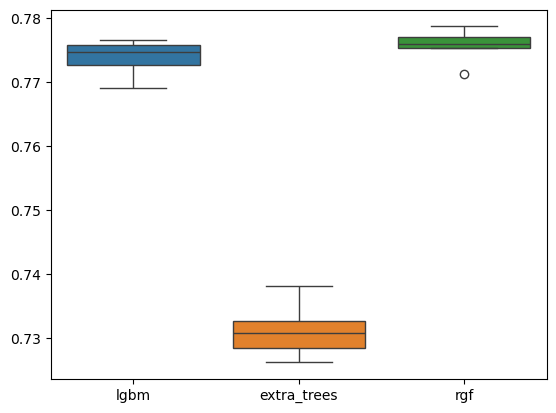

In [22]:
fig_scores,ax_scores=plt.subplots()
sns.boxplot(scores)
ax_scores.set_xticklabels(scores.columns)
plt.show()

### Model Stacking

In [23]:
final_estimator = LGBMClassifier(random_state=1, n_jobs=1,verbose=-1)
model_stack = tr.SimplerStacker(
    [model.pipeline for model in models.models.values()],
    final_estimator=final_estimator,
)

In [27]:
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
stacked_model_scores=[]
with mlflow.start_run(run_name=f"stacked_model_cross_val") as run:
    for i, (train_index, test_index) in enumerate(splitter.split(X_train,y_train)):
        model_stack.fit(X_train[train_index],y_train[train_index])
        preds=model_stack.predict_proba(X_train[test_index])[:,1]
        roc_auc=roc_auc_score(y_train[test_index],preds)
        stacked_model_scores.append(roc_auc)
        mlflow.log_metric(f"roc_auc_{i+1}",roc_auc)
    mlflow.log_metric("mean_roc_auc",np.array(stacked_model_scores).mean())
mlflow.end_run()
joblib.dump(stacked_model_scores,"temp/stack_scores.joblib")

/home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/home/gediminas/anaconda3/lib/python3.9/site-packages/rgf/utils.py:224: UserWarn

In [ ]:
stacked_model_scores

[0.7300480775310794]

In [ ]:
models.models['lgbm'].pipeline['model'].model.feature_importances_

array([ 33, 157, 103,  92,  31, 139,  91,  45,  74,  60,  11,  29, 170,
       158, 147,  22,  48,  14,  19,  35,  37,  38,  41,  17,  20,  10,
        36,  29,  47,  45,  33,  28,  31,  20,  16,  28,  31,  41,  40,
        20,  26,  51,  24,  36,  66,  31,  23,  28,  93,  13,  29,  25,
       113,  41,  56,  40,  13,  36,  28,  35,  15,  68,  24], dtype=int32)

In [ ]:
cols=models.models['lgbm'].pipeline['preprocess'].fit_transform(X_train,y_train).columns

In [ ]:
feats=pl.DataFrame({'imp':models.models['lgbm'].pipeline['model'].model.feature_importances_,'feat':cols})
feats.sort('imp')[-6,1]

'prev_payment_left'

In [ ]:
eda.table_display(feats.sort("imp"))

|   imp | feat                                     |
|------:|:-----------------------------------------|
|    10 | bureau_AMT_CREDIT_MAX_OVERDUE_max        |
|    11 | FLAG_WORK_PHONE                          |
|    13 | prev_AMT_CREDIT_sum_Revolving_loans      |
|    13 | NAME_INCOME_TYPE                         |
|    14 | FLAG_DOCUMENT_3                          |
|    15 | WEEKDAY_APPR_PROCESS_START               |
|    16 | bureau_DAYS_CREDIT_ENDDATE_sum_Active    |
|    17 | bureau_AMT_CREDIT_MAX_OVERDUE_mean       |
|    19 | AMT_REQ_CREDIT_BUREAU_QRT                |
|    20 | bureau_AMT_CREDIT_MAX_OVERDUE_sum        |
|    20 | bureau_DAYS_CREDIT_ENDDATE_mean_Active   |
|    20 | bureau_AMT_CREDIT_SUM_DEBT_mean_Active   |
|    22 | DEF_30_CNT_SOCIAL_CIRCLE                 |
|    23 | prev_AMT_CREDIT_sum_Refused              |
|    24 | bureau_DAYS_CREDIT_mode_Active           |
|    24 | NAME_CONTRACT_TYPE_Cash loans            |
|    25 | prev_count_Refused                       |
|    26 | bureau_AMT_CREDIT_SUM_DEBT_min_Active    |
|    28 | bureau_DAYS_CREDIT_max                   |
|    28 | bureau_DAYS_CREDIT_ENDDATE_min_Active    |
|    28 | prev_AMT_CREDIT_mean_Consumer_loans      |
|    28 | NAME_FAMILY_STATUS                       |
|    29 | REGION_RATING_CLIENT_W_CITY              |
|    29 | bureau_AMT_CREDIT_SUM_sum                |
|    29 | prev_count_Approved                      |
|    31 | REGION_POPULATION_RELATIVE               |
|    31 | bureau_DAYS_CREDIT_mode                  |
|    31 | bureau_DAYS_CREDIT_ENDDATE_max_Active    |
|    31 | prev_AMT_CREDIT_mean_Refused             |
|    33 | AMT_INCOME_TOTAL                         |
|    33 | bureau_DAYS_CREDIT_mean                  |
|    35 | bureau_DAYS_CREDIT_ENDDATE_max           |
|    35 | OCCUPATION_TYPE                          |
|    36 | bureau_AMT_CREDIT_SUM_mean               |
|    36 | bureau_count_Active                      |
|    36 | NAME_EDUCATION_TYPE                      |
|    37 | bureau_DAYS_CREDIT_ENDDATE_mode          |
|    38 | bureau_DAYS_ENDDATE_FACT_max             |
|    40 | bureau_AMT_CREDIT_SUM_min_Active         |
|    40 | CODE_GENDER                              |
|    41 | bureau_DAYS_ENDDATE_FACT_std             |
|    41 | bureau_AMT_CREDIT_MAX_OVERDUE_sum_Active |
|    41 | prev_AMT_BALANCE_CURR_sum                |
|    45 | DAYS_REGISTRATION                        |
|    45 | bureau_AMT_CREDIT_SUM_DEBT_mean          |
|    47 | bureau_AMT_CREDIT_SUM_max                |
|    48 | DAYS_LAST_PHONE_CHANGE                   |
|    51 | bureau_DAYS_CREDIT_max_Active            |
|    56 | prev_curr_bal_lim_diff_sum               |
|    60 | OWN_CAR_AGE                              |
|    66 | prev_AMT_CREDIT_sum_Approved             |
|    68 | ORGANIZATION_TYPE                        |
|    74 | DAYS_ID_PUBLISH                          |
|    91 | DAYS_EMPLOYED                            |
|    92 | AMT_GOODS_PRICE                          |
|    93 | prev_AMT_CREDIT_sum_Consumer_loans       |
|   103 | AMT_ANNUITY                              |
|   113 | prev_payment_left                        |
|   139 | DAYS_BIRTH                               |
|   147 | EXT_SOURCE_3                             |
|   157 | AMT_CREDIT                               |
|   158 | EXT_SOURCE_2                             |
|   170 | EXT_SOURCE_1                             |

In [ ]:
scores = []
for train_index, test_index in StratifiedKFold(5).split(X_train, y_train):
    models.models["lgbm"].pipeline.fit(
        X_train[train_index], y_train[train_index]
    )
    scores.append(
        roc_auc_score(
            y_train[test_index],
            models.models["lgbm"].pipeline.predict_proba(
                X_train[test_index]
            )[:,1],
        )
    )